In [20]:
# -*- coding: utf8

from scipy import stats as ss

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.rcParams['figure.figsize']  = (18, 10)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4

In [21]:
plt.ion()
plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize']  = (12, 8)

/var/folders/q8/9d5d2vtj4832w_98dq64xxr00000gn/T/ipykernel_57587/156476233.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


In [22]:
def despine(ax=None):
    if ax is None:
        ax = plt.gca()
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

# Aula 5 - Regularização e Viés-Variância

Nesta aula, iremos adicionar o conceito de regularização aos nossos modelos. Vamos continuar nosso foco nos dados de preços de apartamentos em BH e utilizar o modelo de regressão múltipla visto na Aula 4.



## Relembrando a Aula 4

### Dados

Relembrando, temos 4 possíveis preditores de preço:
1. Área
1. Quartos
1. Suítes
1. Vagas

In [23]:
df = pd.read_csv('https://raw.githubusercontent.com/icd-ufmg/material/master/'\
                 'aulas/19-Multipla/aptosBH.txt', index_col=0)
df.reset_index(inplace=True)
df.head()

,ID,area,quartos,suites,vagas,preco
0,353534.0,110.00,3.0,1.0,2.0,880000.0
1,366113.0,101.89,3.0,1.0,4.0,900000.0
2,186728.0,191.00,3.0,1.0,3.0,920000.0
3,366115.0,101.89,3.0,1.0,4.0,950000.0
4,353022.0,280.61,3.0,1.0,4.0,1000000.0


Cada preditor é correlacionado com o preço de alguma forma. No pairplot abaixo, observe a última coluna, onde cada linha corresponde a um preditor.

/opt/homebrew/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


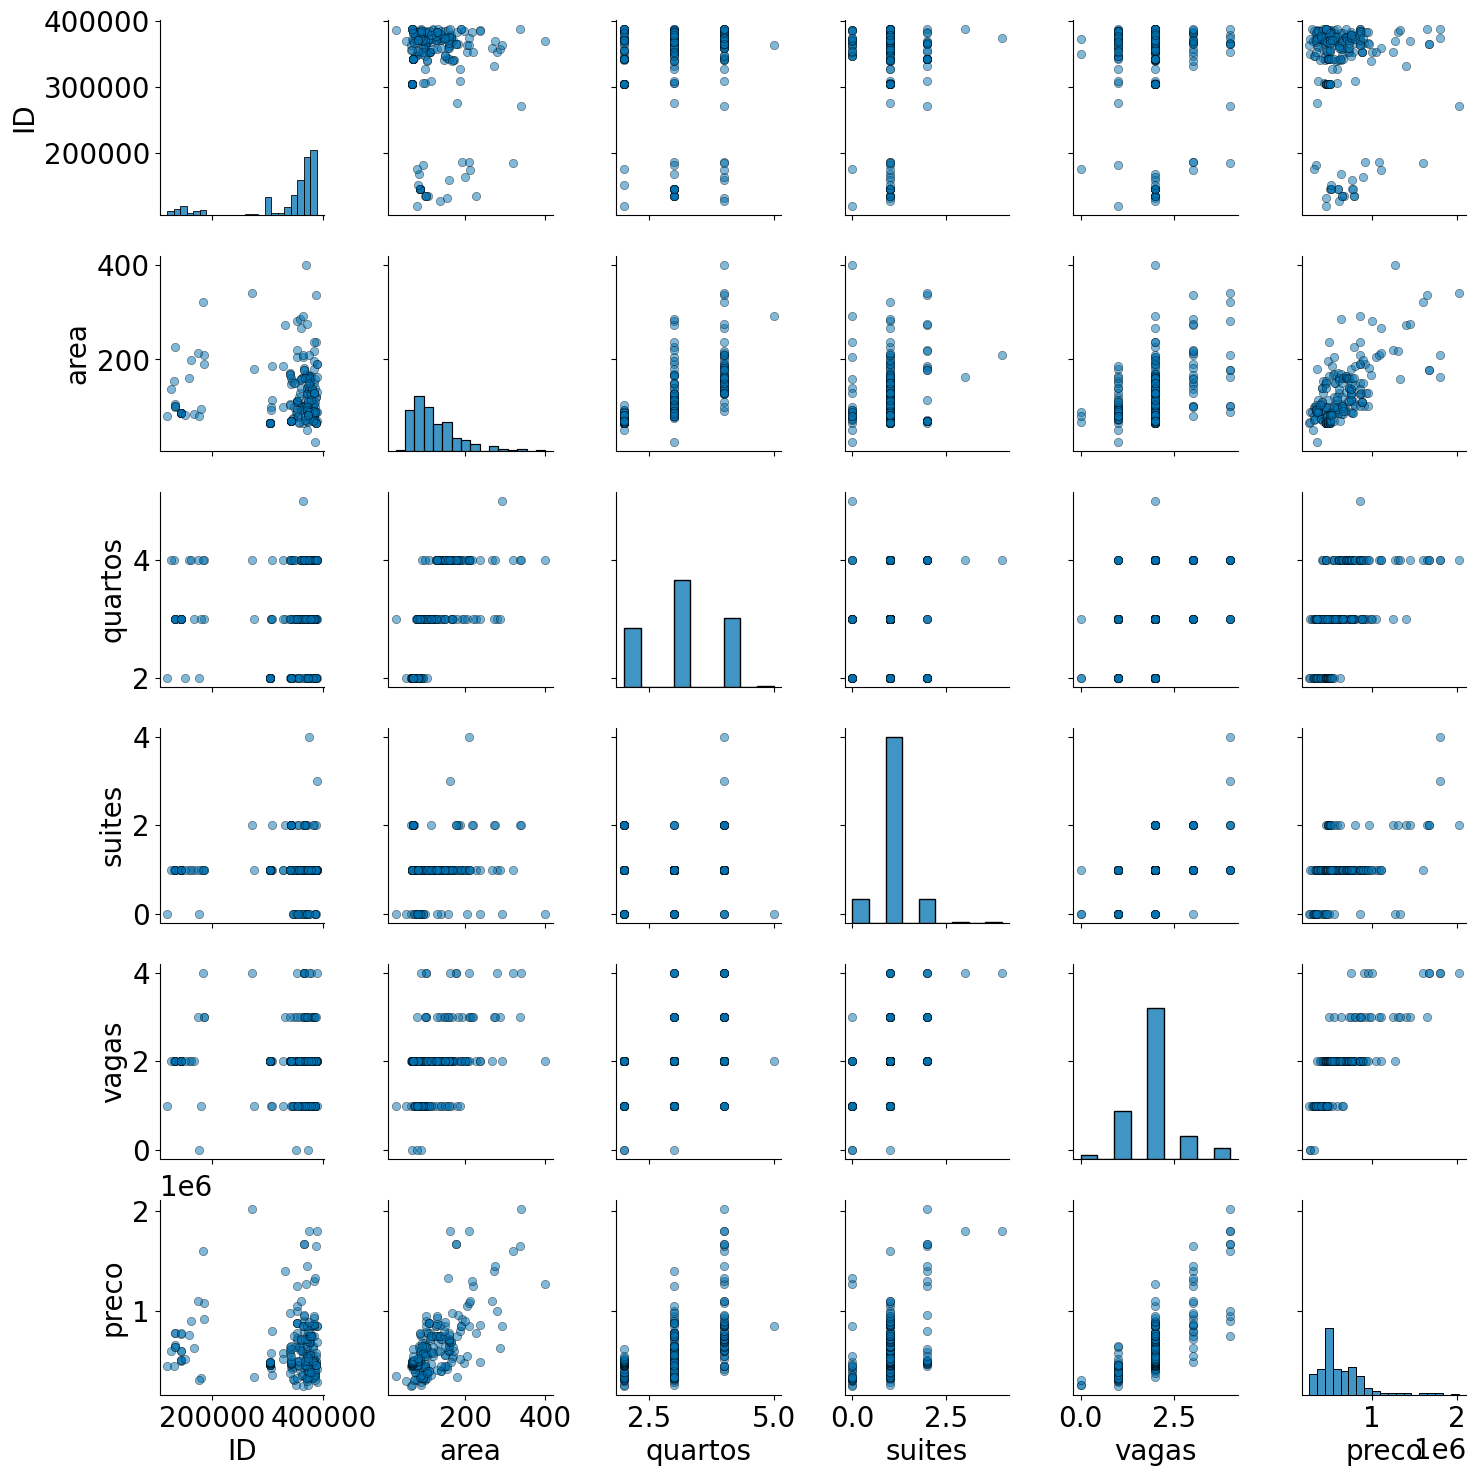

In [24]:
sns.pairplot(df, diag_kws={'edgecolor':'k'}, plot_kws={'alpha':0.5, 'edgecolor':'k'})

### Regressão Múltipla

Para realizar uma regressão múltipla, vamos representar nossos dados na forma matricial. Sendo `n` o número de linhas nos nossos dados (observações) e `f` o número de colunas (features/atríbutos). Os dados podem ser vistos como a matriz abaixo:

$$
\mathbf{X} = \begin{pmatrix}\mathbf {x} _{1}^{\mathsf {T}}\\\mathbf {x} _{2}^{\mathsf {T}}\\\vdots \\\mathbf {x} _{n}^{\mathsf {T}}\end{pmatrix} =\begin{pmatrix}1&x_{11}&\cdots &x_{1f}\\1&x_{21}&\cdots &x_{2f}\\\vdots &\vdots &\ddots &\vdots \\1&x_{n1}&\cdots &x_{nf}\end{pmatrix}
$$

Observe como a primeira coluna é toda `1`. A mesma vai capturar o fator constante, intercepto, da regressão linear. O nosso modelo é capturado pela equação abaixo:

$$y_i = \theta_0 x_{i0} + \theta_1 x_{i1}^{1} + \theta_2 x_{i2}^{2} + \cdots + \theta_f x_{if}^{f} + \epsilon_i$$

Aqui, $x_{i0} = 1$ sempre (por isso usamos uma coluna de 1s). Dessa forma, obtemos a equação:

$$y_i = \theta_0 + \theta_1 x_{i1}^{1} + \theta_2 x_{i2}^{2} + \cdots + \theta_f x_{if}^{f} + \epsilon_i$$

Vamos organizar uma matriz de fatores explanatórios X usando pandas.

In [25]:
df['intercepto'] = 1
y = df['preco']
X = df[['intercepto', 'area', 'quartos', 'suites', 'vagas']]
X.head()

,intercepto,area,quartos,suites,vagas
0,1,110.00,3.0,1.0,2.0
1,1,101.89,3.0,1.0,4.0
2,1,191.00,3.0,1.0,3.0
3,1,101.89,3.0,1.0,4.0
4,1,280.61,3.0,1.0,4.0


Temos 216 observações.

In [26]:
y.shape

(216,)

5 atributos, onde um deles é o intercepto.

In [27]:
X.shape

(216, 5)

X.values retorna a matriz.

In [28]:
X = X.values
y = y.values # pegar a matriz
X

array([[  1.  , 110.  ,   3.  ,   1.  ,   2.  ],
       [  1.  , 101.89,   3.  ,   1.  ,   4.  ],
       [  1.  , 191.  ,   3.  ,   1.  ,   3.  ],
       ...,
       [  1.  ,  70.  ,   2.  ,   2.  ,   2.  ],
       [  1.  ,  70.  ,   2.  ,   2.  ,   2.  ],
       [  1.  , 115.  ,   3.  ,   1.  ,   2.  ]])

### Normalização dos dados

A normalização dos dados pode ser útil para ajudar o gradiente. O algoritmo funciona sem tal passo, porém é mais chato definir uma taxa de aprendizado quando não temos isto e, além disso, a convergência é mais lenta.

Quando as features aparecem com ordens de grandeza muito diferentes (ex: idade entre 0 a 100 e renda mensal entre  800 e 100.000 reais) a função de custo é distorcida, tornando o ponto mínimo difícil de alcançar. Sendo assim, um truque importante é garantir que todos as features estejam em uma escala similar.

Abaixo normalizamos as features dos dados de preços de apartamentos em BH e, em seguida, calculamos o gradiente descendente e o gradiente descendente estocástico.

In [29]:
df = pd.read_csv('https://raw.githubusercontent.com/icd-ufmg/material/master/'\
                 'aulas/19-Multipla/aptosBH.txt', index_col=0)
z_df = (df - df.mean())/df.std()

y = z_df['preco']
X = z_df[['area', 'quartos', 'suites', 'vagas']]
X['intercepto'] = 1

X = X.values
y = y.values

### Erros e Validação

Ainda podemos usar o R-quadrado para avaliar a qualidade de uma regressão linear múltipla. A interpretação permanece a mesma: quanto da variância dos dados é capturada pelo modelo.

In [30]:
def erro(X, y, theta):
    return y - X@theta

def multiple_r_squared(X, y, theta):
    sse = sum(erro(X, y, theta)**2)
    sst = sum((y - np.mean(y))**2)
    return 1.0 - sse / sst

## Gradiente Descendente com Regularização L2

Vamos retomar a implementação do gradiente descendente da Aula 4. Após definir o modelo, a função de erro e a Jacobiana para a regressão múltipla, podemos calcular o gradiente descendente. Contudo, desta vez adicionaremos o termo de regularização L2 para tentar controlar o problema de viés-variância.



Como visto anteriormente, a função de perda na forma matricial é:

$$L({\boldsymbol {\theta }}) = ||\mathbf{y} - \mathbf{X} {\boldsymbol {\theta }}||^2_2$$

Adicionando a penalidade:

$$L({\boldsymbol {\theta }}) = ||\mathbf{y} - \mathbf{X} {\boldsymbol {\theta }}||^2_2 + \beta||{\boldsymbol {\theta }}||^2_2 $$

Carregando módulos de testes

In [31]:
from numpy.testing import assert_almost_equal
from numpy.testing import assert_equal

from numpy.testing import assert_array_almost_equal
from numpy.testing import assert_array_equal

#### Exercício 1

Anteriormente, tínhamos a seguinte função para calcular a matriz Jacobiana:

In [32]:
def derivadas_regressao(theta, X, y):
    return -2 * ((y - X @ theta) @ X)

Como podemos modificar a função `derivadas_regressao` para adicionar o termo de regularização?

Dica: você provavelmente irá precisar de adicionar 1 argumento à chamada da função.

In [33]:
# A keyword "pass" em python indica apenas que não temos nada
# para executar na função.
# Delete "pass" e complete a função abaixo.
# Não se esqueça de adicionar os argumentos necessários
# para executar a sua função.
def derivadas_regressao_reg(theta,X,y,lambda_):
    m = len(y)
    regularizacao = lambda_ * theta

    return -2 * ((y - X @ theta) @ X) + regularizacao
    

#### Exercício 2

Agora, vamos relembrar a implementação do gradiente descentende:

In [34]:
def gd(theta, d_fun, X, y, lambda_=0.0001, tol=0.00001, max_iter=10000):
    theta = theta.copy()
    #print('Iter {}; theta = '.format(0), theta)
    old_err_sq = np.inf
    i = 0
    while True:
        # Computar as derivadas
        grad = d_fun(theta, X, y)
        # Atualizar
        theta_novo = theta - lambda_ * grad

        # Parar quando o erro convergir
        err_sq = ((X.dot(theta) - y) ** 2).mean()
        if np.abs(old_err_sq - err_sq) <= tol:
            break
        theta = theta_novo
        old_err_sq = err_sq
        #print('Iter {}; theta = '.format(i+1), theta)
        i += 1
        if i == max_iter:
            break
    return theta

Novamente, como podemos modificar a função acima para adicionar o termo de regularização?

Dica: você provavelmente irá precisar de adicionar 1 argumento à chamada da função.

In [52]:
def gd_reg(theta, d_fun, X, y, beta, lambda_=0.0001, tol=0.00001, max_iter=10000):
    theta = theta.copy()
    old_err_sq = np.inf
    i = 0
    while True:
        # Computar as derivadas com o termo de regularização
        grad = d_fun(theta, X, y, lambda_)
        # Atualizar
        theta_novo = theta - lambda_ * (grad + (2 * beta * theta))

        # Parar quando o erro convergir
        err_sq = ((X.dot(theta) - y) ** 2).mean()
        if np.abs(old_err_sq - err_sq) <= tol:
            break
        theta = theta_novo
        old_err_sq = err_sq
        i += 1
        if i == max_iter:
            break
    return theta

### Exercício 3 (Sem correcao)

Dependendo de como você fez as implementações dos exercícios acima, um pequeno erro pode passar despercebido. Você sabe apontar o problema?

Dica: https://www.textbook.ds100.org/ch/16/reg_ridge.html

### Exercício 4

Ainda considerando o exemplo da predição do preço de apartamentos em BH, calcule o valor do R-quadrado da regressão com regularização L2, utilizando $\beta=0.1$. Compare com os resultados sem o termo de regularização.

Mais um detalhe: não se esqueça de separar seus dados em treino e teste para que possamos avaliar a qualidade do nosso modelo. Você pode utilizar a função `train_test_split`, da biblioteca sklearn.

```
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# test_size: porcentagem dos dados que serão utilizados para treino, valor default = 0.33
# random_state: semente para amostragem aleatória dos conjuntos de treino e teste, valor default = 42
```

Importando os dados e dividindo em conjuntos de treino e de teste:

In [41]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('https://raw.githubusercontent.com/icd-ufmg/material/master/'\
                 'aulas/19-Multipla/aptosBH.txt', index_col=0)
z_df = (df - df.mean())/df.std()

y = z_df['preco']
X = z_df[['area', 'quartos', 'suites', 'vagas']]
X['intercepto'] = 1

X = X.values
y = y.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#### Regressão sem regularização

In [42]:
theta = np.ones(5)
theta = gd(theta, derivadas_regressao, X_train, y_train)

print("R2 em treino sem regularizacao = ", multiple_r_squared(X_train, y_train, theta))
print("R2 em teste sem regularizacao = ", multiple_r_squared(X_test, y_test, theta))

R2 em treino sem regularizacao =  0.7903872923299036
R2 em teste sem regularizacao =  0.7236500429272194


#### Regressão com regularização L2

 Para $\beta=0.1$:

In [70]:
beta = 0.1
# complete o código
# lembre-se de usar X_train e y_train para obter os valores de theta
theta_inicial = np.ones(X_train.shape[1])
theta_reg = gd_reg(theta_inicial, derivadas_regressao_reg, X_train, y_train, beta)

# não altere as próximas linhas
r2_train = multiple_r_squared(X_train, y_train, theta_reg)
r2_test =  multiple_r_squared(X_test, y_test, theta_reg)

assert_almost_equal(np.round(r2_train,4), np.round(0.79,4),decimal=2)
assert_almost_equal(np.round(r2_test,4), np.round(0.722,4),decimal=2)

Para $\beta=0.01$:

In [71]:
beta = 0.01
# complete o código
# lembre-se de usar X_train e y_train para obter os valores de theta
theta_inicial = np.ones(X_train.shape[1])
theta_reg = gd_reg(theta_inicial, derivadas_regressao_reg, X_train, y_train,beta)

# não altere as próximas linhas
r2_train = multiple_r_squared(X_train, y_train, theta_reg)
r2_test =  multiple_r_squared(X_test, y_test, theta_reg)

assert_almost_equal(np.round(r2_train,4), np.round(0.7903,4),decimal=2)
assert_almost_equal(np.round(r2_test,4), np.round(0.7235,4),decimal=2)

Para $\beta=1$:

In [72]:
beta = 1
# complete o código
# lembre-se de usar X_train e y_train para obter os valores de theta
theta_inicial = np.ones(X_train.shape[1])
theta_reg = gd_reg(theta_inicial, derivadas_regressao_reg, X_train, y_train, beta) 

# não altere as próximas linhas
r2_train = multiple_r_squared(X_train, y_train, theta_reg)
r2_test =  multiple_r_squared(X_test, y_test, theta_reg)

assert_almost_equal(np.round(r2_train,2), np.round(0.7878,2),decimal=2)
assert_almost_equal(np.round(r2_test,2), np.round(0.7148,2),decimal=2)

# sklearn: RidgeRegression (sem correcao automatica)

Por último, temos um exemplo de regressão linear com regularização L2 utilizando a biblioteca sklearn. Neste exemplo, iremos utilizar a *Ridge Regression*, mas note que o sklearn também oferece outras alternativas, como o [*Stochastic Gradient Descent Regressor*](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html).

Ainda, vamos utilizar a versão com validação cruzada, *RidgeCV*, cuja documentação você encontra [aqui](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html). Caso prefira, você também pode aprender sobre a função *Ridge* sem validação cruzada [aqui](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html).

In [ ]:
# exemplo 1
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# No sklearn, o coeficiente de regularizacao recebe o nome de alpha
clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train, y_train, )

print("R2 (treino): ", clf.score(X_train, y_train))
print("R2 (teste): ", clf.score(X_test, y_test))
print("Melhor valor de beta encontrado na validacao cruzada: ", clf.alpha_)

R2 (treino):  0.7958839036561409
R2 (teste):  0.6975259549205053
Melhor valor de beta encontrado na validação cruzada:  1.0


In [ ]:
# exemplo 2
from sklearn.datasets import load_diabetes
from sklearn.linear_model import RidgeCV

X, y = load_diabetes(return_X_y=True)
clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X, y)
clf.score(X, y)

0.5166287840315831

Tente reproduzir os exemplos acima utilizando outras bases de dados e alterando os parâmetros das funções `train_test_spit` e `RidgeCV`. Para facilitar, você pode utilizar alguns dos conjuntos de dados que o sklearn oferece, descritos [aqui](https://scikit-learn.org/stable/datasets/index.html).

In [ ]:
# exercício opcional